In [28]:
import pandas as pd
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Introduction

## Problem Type

Poisson regression is the kind of regression we do when we want to estimate the effect that our explanatory variables have on the dependent variable, which is of type "count data". If we're trying to find a linear combination of the explanatory variables, then our Poisson regression is a subset of generalized linear models.

It's "Poisson" mainly because we use the Poisson distribution to model the likelihood of the dependent variable.

What we get out of this type of model is the relative contribution of each explanatory variable to the value of the dependent variable.

## Data structure

To use it with this model, the data should be structured as such:

- Each row is one measurement.
- The columns should be:
    - One column per explanatory variable.
        - Use ordinal data where possible; otherwise, strictly categorical data should be binarized.
    - One column for the dependent variable.

## Extensions to the model

None.

## Reporting summarized findings

Here are examples of how to summarize the findings.

> For every increase in $X_i$, we expect to see an increase in Y by `mean` (95% HPD: [`lower`, `upper`].

## Other notes

None.

# Exploratory Data Analysis

In [29]:
df = pd.read_csv('datasets/ship-damage.txt')
# Log10 transform months
df['months'] = df['months'].apply(lambda x: np.log10(x))
df['period_op'] = df['period_op'] - 1
df.head()

,type,yr_construction,period_op,months,n_damages
0,1,1,0,2.103804,0
1,1,1,1,1.799341,0
2,1,2,0,3.039414,3
3,1,2,1,3.039414,4
4,1,3,0,3.179552,6


In [30]:
df.shape

(34, 5)

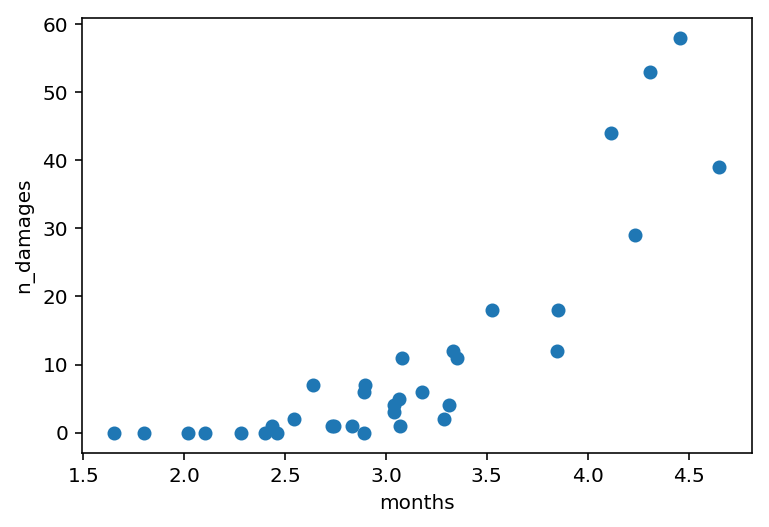

In [31]:
plt.scatter(x=df['months'], y=df['n_damages'])
plt.xlabel('months')
plt.ylabel('n_damages')

In [32]:
import theano.tensor as tt

with pm.Model() as model:
    xs = pm.floatX(df[['yr_construction', 'period_op', 'months']].values)
    betas = pm.Normal('betas', mu=0, sd=100**2, shape=(3, 1))
    n_damages = tt.dot(xs, betas)
    n_damages_like = pm.Poisson('likelihood', mu=np.exp(n_damages), observed=df['n_damages'])
    trace = pm.sample(draws=2000)#, start=pm.find_MAP(), step=pm.Metropolis())

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 16,079:   7%|▋         | 13720/200000 [00:03<00:53, 3509.92it/s]   
Convergence archived at 13900
Interrupted at 13,900 [6%]: Average Loss = 39,128
100%|██████████| 2500/2500 [00:07<00:00, 341.67it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0d4793f5c0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0d4711a080>]], dtype=object)

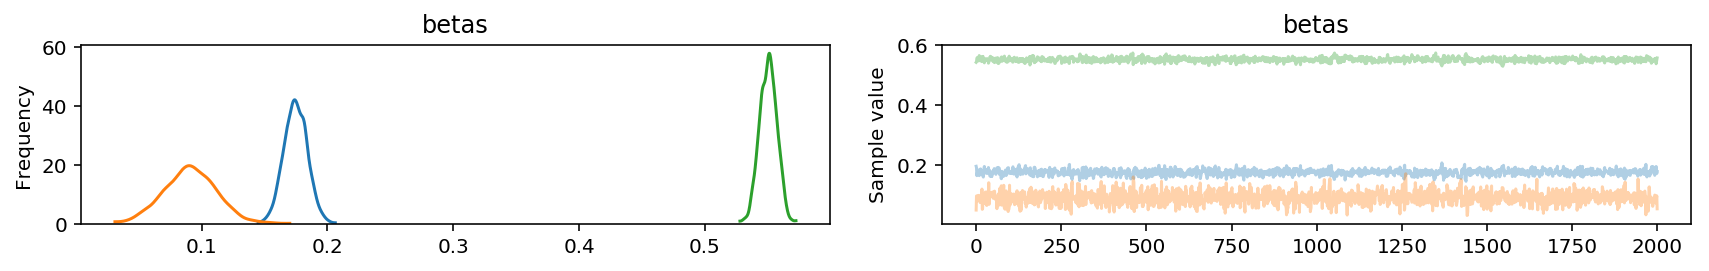

In [33]:
pm.traceplot(trace)

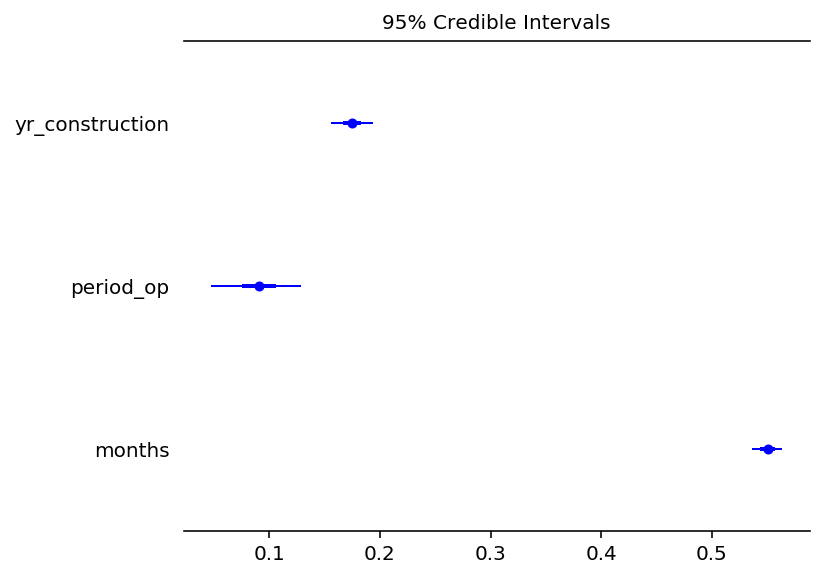

In [34]:
pm.forestplot(trace, ylabels=['yr_construction', 'period_op', 'months'])

The best interpretation of this is that the log10 number of months that a boat has been used is the strongest positive contributor to the number of damages that a ship takes.

In [35]:
pm.summary(trace)


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  0.175            0.009            0.000            [0.157, 0.193]
  ..............................[1, :]...............................
  0.091            0.021            0.001            [0.048, 0.127]
  ..............................[2, :]...............................
  0.550            0.007            0.000            [0.537, 0.563]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  .............................[0, :].............................
  0.157          0.168          0.175          0.181          0.193
  .............................[1, :].............................
  0.051          0.077          0.091          0.104          0.131
  ..........

# Posterior Predictive Checks

Let's see what the PPC looks like. We will sample 10,000 predicted values for each row in the dataframe, and plot the 95% HPD of the values.

In [36]:
with model:
    ppc = pm.sample_ppc(trace, samples=10000)

100%|██████████| 10000/10000 [00:02<00:00, 4324.16it/s]


In [37]:
ppc['likelihood'].shape

(10000, 34, 1)

Let's plot the posterior distribution of predictions vs. actual.

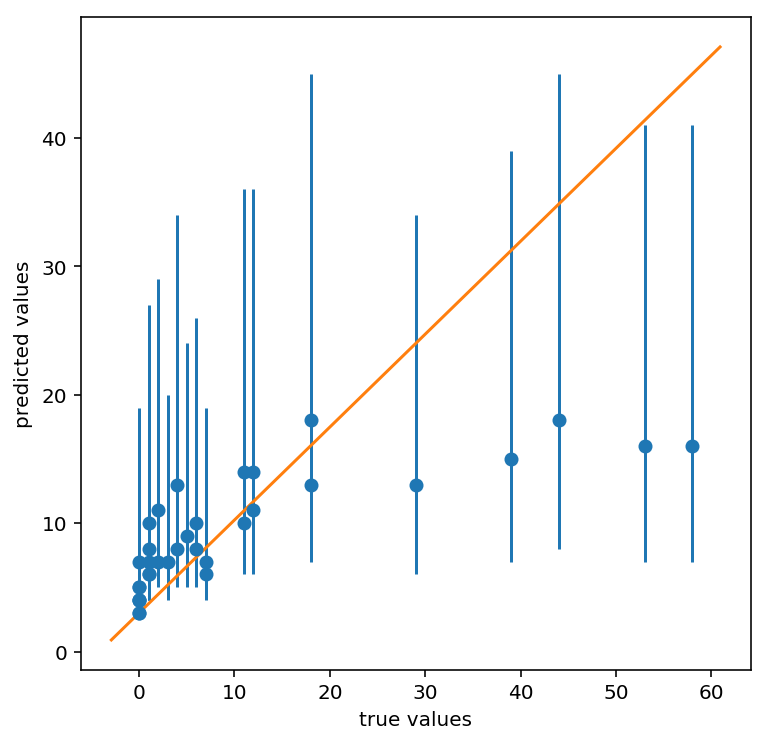

In [38]:
y_true = df['n_damages'].values
lower, med, upper = np.percentile(ppc['likelihood'], [2.5, 50, 97.5], axis=0)

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.errorbar(y_true, med, yerr=[lower, upper], fmt='o')

def x_eq_y(ax):
    xmin, xmax = min(ax.get_xlim()), max(ax.get_xlim())
    ymin, ymax = min(ax.get_ylim()), max(ax.get_ylim())
    
    ax.plot([xmin, xmax], [ymin, ymax])
    return ax

ax = x_eq_y(ax)
ax.set_xlabel('true values')
ax.set_ylabel('predicted values')